In [127]:
#This Python 3 environment comes with many helpful analytics libraries installed
#It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
#For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

#Input data files are available in the read-only "../input/" directory
#For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

#You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
#You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/sentiment-prediction-on-movie-reviews/movies.csv
/kaggle/input/sentiment-prediction-on-movie-reviews/sample.csv
/kaggle/input/sentiment-prediction-on-movie-reviews/train.csv
/kaggle/input/sentiment-prediction-on-movie-reviews/test.csv


# Importing modules

In [128]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.sparse as sp
from datetime import datetime

# Statistical Libraries
from scipy.stats import chi2_contingency
from scipy.stats import mannwhitneyu
from scipy.stats import ttest_ind


# Preprocessing libraries
from sklearn.impute import SimpleImputer,KNNImputer
from sklearn.preprocessing import OneHotEncoder,StandardScaler,MaxAbsScaler,LabelEncoder,FunctionTransformer
from sklearn.pipeline import Pipeline,make_pipeline,FeatureUnion
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.decomposition import PCA,TruncatedSVD

#train test split
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate,cross_val_score

# model evalution matrics
from sklearn.metrics import accuracy_score,ConfusionMatrixDisplay,classification_report,roc_curve,f1_score
from sklearn.metrics import ConfusionMatrixDisplay,confusion_matrix
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

#models
from sklearn.linear_model import LogisticRegressionCV,LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC,NuSVC,SVC

#imbalanced data libraries
from imblearn.ensemble import BalancedBaggingClassifier,BalancedRandomForestClassifier,EasyEnsembleClassifier,RUSBoostClassifier
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler,SMOTE,SVMSMOTE,ADASYN
from imblearn.pipeline import make_pipeline as imb_make_pipeline

#visualising data pipline
from sklearn import set_config

set_config(display='diagram')



# Data Gathering

In [129]:
# this dataset provides metadata on movies
movies=pd.read_csv("/kaggle/input/sentiment-prediction-on-movie-reviews/movies.csv")

# this dataframe provide the training data to build an predictive model
train=pd.read_csv("/kaggle/input/sentiment-prediction-on-movie-reviews/train.csv")

# test set represent the data on which I want to make prediction
test=pd.read_csv("/kaggle/input/sentiment-prediction-on-movie-reviews/test.csv")

# Overview of all the datasets

## Train dataset overview

In [130]:
train.head()

,movieid,reviewerName,isFrequentReviewer,reviewText,sentiment
0,marvelous_pirate,Benjamin Henry,False,Henry Selick’s first movie since 2009’s Corali...,POSITIVE
1,tony_montana_frodo_baggins_v_rocky_balboa,Felicia Lopez,False,With a cast that reads like the Vogue Oscar pa...,NEGATIVE
2,darth_vader_katniss_everdeen_sorcerer_donnie_d...,Mr. Charles Burgess,True,Creed II does not give us anything but another...,POSITIVE
3,lara_croft_glimmer,Ryan Barrett,False,"I know what you're thinking, but this is no Li...",POSITIVE
4,jason_bourne_surreal_the_terminator_indiana_jones,Alexander Glover,False,Director Fernando Meirelles tells the story wi...,POSITIVE


In [131]:
# shape
train.shape

(162758, 5)

In [132]:
# info
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 162758 entries, 0 to 162757
Data columns (total 5 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   movieid             162758 non-null  object
 1   reviewerName        162758 non-null  object
 2   isFrequentReviewer  162758 non-null  bool  
 3   reviewText          156311 non-null  object
 4   sentiment           162758 non-null  object
dtypes: bool(1), object(4)
memory usage: 5.1+ MB


In [133]:
# percent missing values
(train.isnull().sum()/train.shape[0]).round(4)*100

movieid               0.00
reviewerName          0.00
isFrequentReviewer    0.00
reviewText            3.96
sentiment             0.00
dtype: float64

In [134]:
# duplicate rows
train.duplicated().sum()

1118

In [135]:
# dropping the dupllicates before proceeding
train.drop_duplicates(inplace=True)

In [136]:
# columns
train.columns

Index(['movieid', 'reviewerName', 'isFrequentReviewer', 'reviewText',
       'sentiment'],
      dtype='object')

## Test data overview

In [137]:
test.head()

,movieid,reviewerName,isTopCritic,reviewText
0,legend_marty_mcfly_oracle,John Kim,False,Green slowly cranks up the dread with style an...
1,terminator_katniss_everdeen_glimmer,Brian Chaney,False,Philip Noyce's direction is elegant and unforc...
2,james_bond_labyrinth_gollum,Danielle Parker,False,It wouldn't do to say what path Maria ultimate...
3,v_quest_han_solo_wondrous,Brittany Lane,False,Pig is not exactly the arthouse John Wick that...
4,enigma_hulk_surreal_starlight,Justin Willis,False,An imaginative no-budget musical of sorts abou...


In [138]:
# info
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55315 entries, 0 to 55314
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   movieid       55315 non-null  object
 1   reviewerName  55315 non-null  object
 2   isTopCritic   55315 non-null  bool  
 3   reviewText    52805 non-null  object
dtypes: bool(1), object(3)
memory usage: 1.3+ MB


In [139]:
# percent missing values
(test.isnull().sum()/train.shape[0]).round(4)*100

movieid         0.00
reviewerName    0.00
isTopCritic     0.00
reviewText      1.55
dtype: float64

In [140]:
# columns
test.columns

Index(['movieid', 'reviewerName', 'isTopCritic', 'reviewText'], dtype='object')

## Movies dataset overview

In [141]:
movies.head()

,movieid,title,audienceScore,rating,ratingContents,releaseDateTheaters,releaseDateStreaming,runtimeMinutes,genre,originalLanguage,director,boxOffice,distributor,soundType
0,han_solo_heroic_myth_wonder_woman,Han Solo Heroic Myth Wonder Woman,50.0,NaN,NaN,NaN,2018-08-25,75.0,"Comedy, Horror, Sci-fi",English,Claude Nicolet,NaN,NaN,NaN
1,voyage_tyler_durden_han_solo_stardust,Voyage Tyler Durden Han Solo Stardust,NaN,NaN,NaN,NaN,2020-02-11,114.0,Drama,English,Nathan Haack,NaN,NaN,NaN
2,norman_bates_ferris_bueller_hermione_granger_v...,Norman Bates Ferris Bueller Hermione Granger V...,43.0,NaN,NaN,NaN,NaN,120.0,Drama,Korean,Theresa Smith,NaN,NaN,NaN
3,elegant_hermione_granger,Elegant Hermione Granger,60.0,NaN,NaN,NaN,2020-10-23,90.0,"Action, Mystery & thriller",English,Donald Lewis,NaN,NaN,NaN
4,adventure_rocky_balboa,Adventure Rocky Balboa,70.0,NaN,NaN,NaN,2017-03-27,80.0,"Fantasy, Adventure, Animation",English,Howard Simms,NaN,NaN,NaN


In [142]:
#shape of movies datset
movies.shape

(143258, 14)

In [143]:
# duplicate rows
movies.duplicated().sum()

1571

In [144]:
# dropping the dupllicates before proceeding
movies.drop_duplicates(inplace=True)

In [145]:
#information about movies dataset
movies.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 141687 entries, 0 to 143257
Data columns (total 14 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   movieid               141687 non-null  object 
 1   title                 141687 non-null  object 
 2   audienceScore         72628 non-null   float64
 3   rating                13856 non-null   object 
 4   ratingContents        13856 non-null   object 
 5   releaseDateTheaters   30512 non-null   object 
 6   releaseDateStreaming  78730 non-null   object 
 7   runtimeMinutes        128314 non-null  float64
 8   genre                 131030 non-null  object 
 9   originalLanguage      128282 non-null  object 
 10  director              141687 non-null  object 
 11  boxOffice             14616 non-null   object 
 12  distributor           22803 non-null   object 
 13  soundType             15785 non-null   object 
dtypes: float64(2), object(12)
memory usage: 16.2+ MB


In [146]:
# percent missing value
(movies.isnull().sum()/movies.shape[0]*100).round(2)

movieid                  0.00
title                    0.00
audienceScore           48.74
rating                  90.22
ratingContents          90.22
releaseDateTheaters     78.47
releaseDateStreaming    44.43
runtimeMinutes           9.44
genre                    7.52
originalLanguage         9.46
director                 0.00
boxOffice               89.68
distributor             83.91
soundType               88.86
dtype: float64

In [147]:
# mocies columns
movies.columns

Index(['movieid', 'title', 'audienceScore', 'rating', 'ratingContents',
       'releaseDateTheaters', 'releaseDateStreaming', 'runtimeMinutes',
       'genre', 'originalLanguage', 'director', 'boxOffice', 'distributor',
       'soundType'],
      dtype='object')

In [148]:
# numerical colums
movies.select_dtypes('number').columns

Index(['audienceScore', 'runtimeMinutes'], dtype='object')

In [149]:
# other than numeric columns
movies.select_dtypes('object').columns

Index(['movieid', 'title', 'rating', 'ratingContents', 'releaseDateTheaters',
       'releaseDateStreaming', 'genre', 'originalLanguage', 'director',
       'boxOffice', 'distributor', 'soundType'],
      dtype='object')

**Findings**
- There is one column in train set which is not in test set and there is on column in test which is not in train. I can extract the information about the reviewer from both columns and merge this information to train and test set.
- In movies set, there is some column with less missing values which can be merged with train and test set to improve the prediction

# Feature Engineering 

## Creating subset of information from movies, train and test dataset

### Subset of movies data

In [150]:
# columns of movies dataset which i want to merge
cols_to_merge=['movieid', 'audienceScore', 'rating', 'ratingContents',
       'releaseDateTheaters', 'runtimeMinutes','genre', 'originalLanguage', 'director', 'boxOffice', 'distributor',
       'soundType']
movies_new=movies.loc[:,cols_to_merge]
movies_new.head()

,movieid,audienceScore,rating,ratingContents,releaseDateTheaters,runtimeMinutes,genre,originalLanguage,director,boxOffice,distributor,soundType
0,han_solo_heroic_myth_wonder_woman,50.0,NaN,NaN,NaN,75.0,"Comedy, Horror, Sci-fi",English,Claude Nicolet,NaN,NaN,NaN
1,voyage_tyler_durden_han_solo_stardust,NaN,NaN,NaN,NaN,114.0,Drama,English,Nathan Haack,NaN,NaN,NaN
2,norman_bates_ferris_bueller_hermione_granger_v...,43.0,NaN,NaN,NaN,120.0,Drama,Korean,Theresa Smith,NaN,NaN,NaN
3,elegant_hermione_granger,60.0,NaN,NaN,NaN,90.0,"Action, Mystery & thriller",English,Donald Lewis,NaN,NaN,NaN
4,adventure_rocky_balboa,70.0,NaN,NaN,NaN,80.0,"Fantasy, Adventure, Animation",English,Howard Simms,NaN,NaN,NaN


In [151]:
# cheching if there are duplicates in movieid column
movies_new.movieid.duplicated().sum()

15283

**I want to remove these duplicates based on the count of missing values corresponding to each row**

In [152]:
# Calculate the number of missing values in each row
movies_new['missing_values'] = movies_new.isnull().sum(axis=1)
movies_new

,movieid,audienceScore,rating,ratingContents,releaseDateTheaters,runtimeMinutes,genre,originalLanguage,director,boxOffice,distributor,soundType,missing_values
0,han_solo_heroic_myth_wonder_woman,50.0,NaN,NaN,NaN,75.0,"Comedy, Horror, Sci-fi",English,Claude Nicolet,NaN,NaN,NaN,6
1,voyage_tyler_durden_han_solo_stardust,NaN,NaN,NaN,NaN,114.0,Drama,English,Nathan Haack,NaN,NaN,NaN,7
2,norman_bates_ferris_bueller_hermione_granger_v...,43.0,NaN,NaN,NaN,120.0,Drama,Korean,Theresa Smith,NaN,NaN,NaN,6
3,elegant_hermione_granger,60.0,NaN,NaN,NaN,90.0,"Action, Mystery & thriller",English,Donald Lewis,NaN,NaN,NaN,6
4,adventure_rocky_balboa,70.0,NaN,NaN,NaN,80.0,"Fantasy, Adventure, Animation",English,Howard Simms,NaN,NaN,NaN,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...
143253,sherlock_holmes_surreal_james_bond,14.0,NaN,NaN,2002-08-27,90.0,"Action, Adventure, Anime",Japanese,William Sims,NaN,ADV Films,NaN,4
143254,mr._miyagi_katniss_everdeen_harmony,NaN,NaN,NaN,NaN,99.0,Drama,English,Robert Paddock,NaN,NaN,NaN,7
143255,elegant_emerald_valiant_donnie_darko,71.0,NaN,NaN,NaN,43.0,Documentary,English,Roy Lovelace,NaN,NaN,NaN,6
143256,wonder_hermione_granger_hulk_v,NaN,NaN,NaN,NaN,63.0,Drama,English,Dwayne Clayton,NaN,NaN,NaN,7


In [153]:
# Sort the DataFrame by the number of missing values in ascending order
movies_new.sort_values('missing_values', inplace=True)
movies_new

,movieid,audienceScore,rating,ratingContents,releaseDateTheaters,runtimeMinutes,genre,originalLanguage,director,boxOffice,distributor,soundType,missing_values
71452,courageous_hidden_miracle_luke_skywalker,65.0,R,"['Some Disturbing Images', 'Sexual Content', '...",2008-03-07,84.0,Drama,English,Mary Hirko,$486.0K,IFC Films,Dolby,0
121594,journey_vito_corleone_the_terminator_scarlett_...,49.0,R,"['Language', 'Brief Drug Use', 'Sex Scene', 'V...",2002-04-19,120.0,Mystery & thriller,English,Susan Strickland,$31.9M,Warner Bros. Pictures,"Dolby SR, DTS, Dolby Stereo, Surround, SDDS, D...",0
88046,enigma_phenomenal_hannibal_lecter,48.0,R,"['Crude and Sexual Humor', 'Bloody Violence', ...",2015-01-02,111.0,"Comedy, Action, Adventure",English,Morgan Mcdonald,$6.1M,Sony Pictures Entertainment,"Datasat, Dolby Digital",0
88047,tony_montana_annie_hall_treasure,41.0,PG,"['Some Mild Rude Humor', 'Language']",2011-06-10,87.0,"Kids & family, Comedy, Adventure",English,William Barker,$15.0M,Relativity Media,"SDDS, Dolby Digital, DTS",0
121571,tony_stark_sherlock_holmes_magician_james_bond,65.0,PG-13,"['Language', 'Brief Sensuality', 'Mature Thema...",2002-06-07,116.0,"Comedy, Drama",English,Paul Howard,$69.6M,Warner Bros. Pictures,Surround,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
106761,mythical_tyler_durden_heroic_vito_corleone,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Augusta Daniel,NaN,NaN,NaN,10
68022,t-800_the_bride_john_mcclane,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Tina Cuellar,NaN,NaN,NaN,10
33490,hannibal_lecter_john_mcclane_wanderer,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Augusta Daniel,NaN,NaN,NaN,10
124810,jack_torrance_dorothy_gale_ethereal_black_widow,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Augusta Daniel,NaN,NaN,NaN,10


In [154]:
# Drop the duplicate 'movieid' values, keeping the first occurrence (with the minimum missing values)
movies_new.drop_duplicates(subset='movieid', keep='first', inplace=True)
movies_new

,movieid,audienceScore,rating,ratingContents,releaseDateTheaters,runtimeMinutes,genre,originalLanguage,director,boxOffice,distributor,soundType,missing_values
71452,courageous_hidden_miracle_luke_skywalker,65.0,R,"['Some Disturbing Images', 'Sexual Content', '...",2008-03-07,84.0,Drama,English,Mary Hirko,$486.0K,IFC Films,Dolby,0
121594,journey_vito_corleone_the_terminator_scarlett_...,49.0,R,"['Language', 'Brief Drug Use', 'Sex Scene', 'V...",2002-04-19,120.0,Mystery & thriller,English,Susan Strickland,$31.9M,Warner Bros. Pictures,"Dolby SR, DTS, Dolby Stereo, Surround, SDDS, D...",0
88046,enigma_phenomenal_hannibal_lecter,48.0,R,"['Crude and Sexual Humor', 'Bloody Violence', ...",2015-01-02,111.0,"Comedy, Action, Adventure",English,Morgan Mcdonald,$6.1M,Sony Pictures Entertainment,"Datasat, Dolby Digital",0
88047,tony_montana_annie_hall_treasure,41.0,PG,"['Some Mild Rude Humor', 'Language']",2011-06-10,87.0,"Kids & family, Comedy, Adventure",English,William Barker,$15.0M,Relativity Media,"SDDS, Dolby Digital, DTS",0
121571,tony_stark_sherlock_holmes_magician_james_bond,65.0,PG-13,"['Language', 'Brief Sensuality', 'Mature Thema...",2002-06-07,116.0,"Comedy, Drama",English,Paul Howard,$69.6M,Warner Bros. Pictures,Surround,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
106761,mythical_tyler_durden_heroic_vito_corleone,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Augusta Daniel,NaN,NaN,NaN,10
68022,t-800_the_bride_john_mcclane,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Tina Cuellar,NaN,NaN,NaN,10
33490,hannibal_lecter_john_mcclane_wanderer,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Augusta Daniel,NaN,NaN,NaN,10
124810,jack_torrance_dorothy_gale_ethereal_black_widow,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Augusta Daniel,NaN,NaN,NaN,10


In [155]:
# Remove the 'missing_values' column
movies_new.drop('missing_values', axis=1, inplace=True)


In [156]:
# resetting the index
movies_new.reset_index(drop=True,inplace=True)
movies_new

,movieid,audienceScore,rating,ratingContents,releaseDateTheaters,runtimeMinutes,genre,originalLanguage,director,boxOffice,distributor,soundType
0,courageous_hidden_miracle_luke_skywalker,65.0,R,"['Some Disturbing Images', 'Sexual Content', '...",2008-03-07,84.0,Drama,English,Mary Hirko,$486.0K,IFC Films,Dolby
1,journey_vito_corleone_the_terminator_scarlett_...,49.0,R,"['Language', 'Brief Drug Use', 'Sex Scene', 'V...",2002-04-19,120.0,Mystery & thriller,English,Susan Strickland,$31.9M,Warner Bros. Pictures,"Dolby SR, DTS, Dolby Stereo, Surround, SDDS, D..."
2,enigma_phenomenal_hannibal_lecter,48.0,R,"['Crude and Sexual Humor', 'Bloody Violence', ...",2015-01-02,111.0,"Comedy, Action, Adventure",English,Morgan Mcdonald,$6.1M,Sony Pictures Entertainment,"Datasat, Dolby Digital"
3,tony_montana_annie_hall_treasure,41.0,PG,"['Some Mild Rude Humor', 'Language']",2011-06-10,87.0,"Kids & family, Comedy, Adventure",English,William Barker,$15.0M,Relativity Media,"SDDS, Dolby Digital, DTS"
4,tony_stark_sherlock_holmes_magician_james_bond,65.0,PG-13,"['Language', 'Brief Sensuality', 'Mature Thema...",2002-06-07,116.0,"Comedy, Drama",English,Paul Howard,$69.6M,Warner Bros. Pictures,Surround
...,...,...,...,...,...,...,...,...,...,...,...,...
126399,mythical_tyler_durden_heroic_vito_corleone,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Augusta Daniel,NaN,NaN,NaN
126400,t-800_the_bride_john_mcclane,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Tina Cuellar,NaN,NaN,NaN
126401,hannibal_lecter_john_mcclane_wanderer,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Augusta Daniel,NaN,NaN,NaN
126402,jack_torrance_dorothy_gale_ethereal_black_widow,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Augusta Daniel,NaN,NaN,NaN


In [157]:
# checking the percentage of missing value after removing duplicate rows
(movies_new.isnull().sum()/movies.shape[0]*100).round(2)

movieid                 0.00
audienceScore          42.77
rating                 79.94
ratingContents         79.94
releaseDateTheaters    69.02
runtimeMinutes          8.46
genre                   6.78
originalLanguage        8.38
director                0.00
boxOffice              79.31
distributor            73.97
soundType              78.87
dtype: float64

#### Feature Engineering on Movies_new

In [158]:
# Convert 'release_date' to datetime
movies_new['releaseDateTheaters'] = pd.to_datetime(movies_new['releaseDateTheaters'])

# Create new columns for release year and month
movies_new['releaseYear'] = movies_new['releaseDateTheaters'].dt.year
movies_new['releaseMonth'] = movies_new['releaseDateTheaters'].dt.strftime('%B')
movies_new.drop("releaseDateTheaters",axis=1,inplace=True)

movies_new.head()


,movieid,audienceScore,rating,ratingContents,runtimeMinutes,genre,originalLanguage,director,boxOffice,distributor,soundType,releaseYear,releaseMonth
0,courageous_hidden_miracle_luke_skywalker,65.0,R,"['Some Disturbing Images', 'Sexual Content', '...",84.0,Drama,English,Mary Hirko,$486.0K,IFC Films,Dolby,2008.0,March
1,journey_vito_corleone_the_terminator_scarlett_...,49.0,R,"['Language', 'Brief Drug Use', 'Sex Scene', 'V...",120.0,Mystery & thriller,English,Susan Strickland,$31.9M,Warner Bros. Pictures,"Dolby SR, DTS, Dolby Stereo, Surround, SDDS, D...",2002.0,April
2,enigma_phenomenal_hannibal_lecter,48.0,R,"['Crude and Sexual Humor', 'Bloody Violence', ...",111.0,"Comedy, Action, Adventure",English,Morgan Mcdonald,$6.1M,Sony Pictures Entertainment,"Datasat, Dolby Digital",2015.0,January
3,tony_montana_annie_hall_treasure,41.0,PG,"['Some Mild Rude Humor', 'Language']",87.0,"Kids & family, Comedy, Adventure",English,William Barker,$15.0M,Relativity Media,"SDDS, Dolby Digital, DTS",2011.0,June
4,tony_stark_sherlock_holmes_magician_james_bond,65.0,PG-13,"['Language', 'Brief Sensuality', 'Mature Thema...",116.0,"Comedy, Drama",English,Paul Howard,$69.6M,Warner Bros. Pictures,Surround,2002.0,June


#### Feature Engineering on boxOffice column

In [159]:
# Function to convert boxOffice values to actual numbers
def convert_box_office(value):
    if pd.isna(value):
        return value
    
    if 'M' in value:
        return float(value.replace('$', '').replace('M', '')) * 1000000
    elif 'K' in value:
        return float(value.replace('$', '').replace('K', '')) * 1000
    else:
        return None

In [160]:
movies_new.boxOffice=movies_new.boxOffice.apply(convert_box_office)

In [161]:
movies_new.head()

,movieid,audienceScore,rating,ratingContents,runtimeMinutes,genre,originalLanguage,director,boxOffice,distributor,soundType,releaseYear,releaseMonth
0,courageous_hidden_miracle_luke_skywalker,65.0,R,"['Some Disturbing Images', 'Sexual Content', '...",84.0,Drama,English,Mary Hirko,486000.0,IFC Films,Dolby,2008.0,March
1,journey_vito_corleone_the_terminator_scarlett_...,49.0,R,"['Language', 'Brief Drug Use', 'Sex Scene', 'V...",120.0,Mystery & thriller,English,Susan Strickland,31900000.0,Warner Bros. Pictures,"Dolby SR, DTS, Dolby Stereo, Surround, SDDS, D...",2002.0,April
2,enigma_phenomenal_hannibal_lecter,48.0,R,"['Crude and Sexual Humor', 'Bloody Violence', ...",111.0,"Comedy, Action, Adventure",English,Morgan Mcdonald,6100000.0,Sony Pictures Entertainment,"Datasat, Dolby Digital",2015.0,January
3,tony_montana_annie_hall_treasure,41.0,PG,"['Some Mild Rude Humor', 'Language']",87.0,"Kids & family, Comedy, Adventure",English,William Barker,15000000.0,Relativity Media,"SDDS, Dolby Digital, DTS",2011.0,June
4,tony_stark_sherlock_holmes_magician_james_bond,65.0,PG-13,"['Language', 'Brief Sensuality', 'Mature Thema...",116.0,"Comedy, Drama",English,Paul Howard,69600000.0,Warner Bros. Pictures,Surround,2002.0,June


#### Creating the subset from train set

In [162]:
frequent_reviewer=train.loc[:,["reviewerName","isFrequentReviewer"]]
frequent_reviewer.drop_duplicates(keep='first',inplace=True,subset=["reviewerName"])

In [163]:
frequent_reviewer.head()

,reviewerName,isFrequentReviewer
0,Benjamin Henry,False
1,Felicia Lopez,False
2,Mr. Charles Burgess,True
3,Ryan Barrett,False
4,Alexander Glover,False


#### Creating the subset from test set

In [164]:
critic_reviewer=test.loc[:,["reviewerName","isTopCritic"]]
critic_reviewer.drop_duplicates(keep='first',inplace=True,subset=["reviewerName"])

In [165]:
critic_reviewer.head()

,reviewerName,isTopCritic
0,John Kim,False
1,Brian Chaney,False
2,Danielle Parker,False
3,Brittany Lane,False
4,Justin Willis,False


**Now I have created all the subset which I want to merge with train and test set**

## Merging

### Merging with train

In [166]:
# merginf movies_new to train
train_new = train.merge(movies_new, on='movieid', how='left')

# Check the shape of the merged dataset
print("Shape of train_new:", train_new.shape)
print("Shape of train:", train.shape)

Shape of train_new: (161640, 17)
Shape of train: (161640, 5)


In [167]:
# merging train_new  to critic_reviewer
train_new = train_new.merge(critic_reviewer, on='reviewerName', how='left')

# Check the shape of the merged dataset
print("Shape of train_new:", train_new.shape)

Shape of train_new: (161640, 18)


In [168]:
train_new.head()

,movieid,reviewerName,isFrequentReviewer,reviewText,sentiment,audienceScore,rating,ratingContents,runtimeMinutes,genre,originalLanguage,director,boxOffice,distributor,soundType,releaseYear,releaseMonth,isTopCritic
0,marvelous_pirate,Benjamin Henry,False,Henry Selick’s first movie since 2009’s Corali...,POSITIVE,65.0,PG-13,"['Violence', 'Brief Strong Language', 'Substan...",105.0,"Comedy, Animation, Adventure, Fantasy",English,Bennie Basso,NaN,Netflix,NaN,2022.0,October,False
1,tony_montana_frodo_baggins_v_rocky_balboa,Felicia Lopez,False,With a cast that reads like the Vogue Oscar pa...,NEGATIVE,47.0,PG-13,"['Some Sexual Material', 'Brief Partial Nudity']",119.0,"Holiday, Romance, Comedy, Lgbtq+",English,Hubert Dixon,110500000.0,Warner Bros.,"Dolby Digital, DTS",2010.0,February,False
2,darth_vader_katniss_everdeen_sorcerer_donnie_d...,Mr. Charles Burgess,True,Creed II does not give us anything but another...,POSITIVE,80.0,PG-13,"['Language', 'A Scene of Sensuality', 'Sports ...",130.0,Drama,English,Bobby Oleary,115700000.0,"Warner Bros. Pictures, Metro-Goldwyn-Mayer",NaN,2018.0,November,True
3,lara_croft_glimmer,Ryan Barrett,False,"I know what you're thinking, but this is no Li...",POSITIVE,47.0,R,"['Sexuality', 'Disturbing Images', 'Strong Vio...",88.0,"Action, Mystery & thriller, Sci-fi",English,Gail Pugh,126500000.0,Universal Pictures,NaN,2014.0,July,False
4,jason_bourne_surreal_the_terminator_indiana_jones,Alexander Glover,False,Director Fernando Meirelles tells the story wi...,POSITIVE,97.0,R,"['Language', 'Drug Content', 'Sexuality', 'Str...",131.0,"Crime, Drama",Portuguese (Brazil),John Trent,7600000.0,Miramax Films,"Surround, Dolby SR, Dolby Digital, Dolby A, Do...",2003.0,January,False


In [169]:
train_new.columns

Index(['movieid', 'reviewerName', 'isFrequentReviewer', 'reviewText',
       'sentiment', 'audienceScore', 'rating', 'ratingContents',
       'runtimeMinutes', 'genre', 'originalLanguage', 'director', 'boxOffice',
       'distributor', 'soundType', 'releaseYear', 'releaseMonth',
       'isTopCritic'],
      dtype='object')

In [170]:
# column order list
columns_order=['movieid','audienceScore','runtimeMinutes', 'boxOffice', 'releaseYear','releaseMonth',
               'originalLanguage', 'director', 'rating', 'ratingContents', 'genre','distributor', 'soundType',
               'reviewerName', 'isFrequentReviewer','isTopCritic', 'reviewText','sentiment']

In [171]:
# ordering the train_new
train_new=train_new.reindex(columns=columns_order)
train_new.head()

,movieid,audienceScore,runtimeMinutes,boxOffice,releaseYear,releaseMonth,originalLanguage,director,rating,ratingContents,genre,distributor,soundType,reviewerName,isFrequentReviewer,isTopCritic,reviewText,sentiment
0,marvelous_pirate,65.0,105.0,NaN,2022.0,October,English,Bennie Basso,PG-13,"['Violence', 'Brief Strong Language', 'Substan...","Comedy, Animation, Adventure, Fantasy",Netflix,NaN,Benjamin Henry,False,False,Henry Selick’s first movie since 2009’s Corali...,POSITIVE
1,tony_montana_frodo_baggins_v_rocky_balboa,47.0,119.0,110500000.0,2010.0,February,English,Hubert Dixon,PG-13,"['Some Sexual Material', 'Brief Partial Nudity']","Holiday, Romance, Comedy, Lgbtq+",Warner Bros.,"Dolby Digital, DTS",Felicia Lopez,False,False,With a cast that reads like the Vogue Oscar pa...,NEGATIVE
2,darth_vader_katniss_everdeen_sorcerer_donnie_d...,80.0,130.0,115700000.0,2018.0,November,English,Bobby Oleary,PG-13,"['Language', 'A Scene of Sensuality', 'Sports ...",Drama,"Warner Bros. Pictures, Metro-Goldwyn-Mayer",NaN,Mr. Charles Burgess,True,True,Creed II does not give us anything but another...,POSITIVE
3,lara_croft_glimmer,47.0,88.0,126500000.0,2014.0,July,English,Gail Pugh,R,"['Sexuality', 'Disturbing Images', 'Strong Vio...","Action, Mystery & thriller, Sci-fi",Universal Pictures,NaN,Ryan Barrett,False,False,"I know what you're thinking, but this is no Li...",POSITIVE
4,jason_bourne_surreal_the_terminator_indiana_jones,97.0,131.0,7600000.0,2003.0,January,Portuguese (Brazil),John Trent,R,"['Language', 'Drug Content', 'Sexuality', 'Str...","Crime, Drama",Miramax Films,"Surround, Dolby SR, Dolby Digital, Dolby A, Do...",Alexander Glover,False,False,Director Fernando Meirelles tells the story wi...,POSITIVE


#### Merging with test

In [172]:
# merginf movies_new to train
test_new = test.merge(movies_new, on='movieid', how='left')

# Check the shape of the merged dataset
print("Shape of train_new:", test_new.shape)
print("Shape of train:", test.shape)

Shape of train_new: (55315, 16)
Shape of train: (55315, 4)


In [173]:
# merginf test_new to freqeuent_reviewer
test_new = test_new.merge(frequent_reviewer, on='reviewerName', how='left')

# Check the shape of the merged dataset
print("Shape of train_new:", test_new.shape)

Shape of train_new: (55315, 17)


In [174]:
# column order list
columns_order=['movieid','audienceScore','runtimeMinutes', 'boxOffice', 'releaseYear','releaseMonth',
               'originalLanguage', 'director', 'rating', 'ratingContents', 'genre','distributor', 'soundType',
               'reviewerName', 'isFrequentReviewer','isTopCritic', 'reviewText']

In [175]:
# ordering the train_new
test_new=test_new.reindex(columns=columns_order)
test_new.head()

,movieid,audienceScore,runtimeMinutes,boxOffice,releaseYear,releaseMonth,originalLanguage,director,rating,ratingContents,genre,distributor,soundType,reviewerName,isFrequentReviewer,isTopCritic,reviewText
0,legend_marty_mcfly_oracle,57.0,111.0,64000000.0,2022.0,October,English,Sara Barnett,R,"['Gore', 'Bloody Horror Violence', 'Language T...","Holiday, Horror, Mystery & thriller",Universal Pictures,Dolby Atmos,John Kim,False,False,Green slowly cranks up the dread with style an...
1,terminator_katniss_everdeen_glimmer,86.0,94.0,6200000.0,2002.0,November,English,Cindy Flander,PG,['Emotional Thematic Material'],"Drama, Adventure",Miramax Films,"Dolby SR, DTS, Dolby Stereo, Surround, SDDS, D...",Brian Chaney,False,False,Philip Noyce's direction is elegant and unforc...
2,james_bond_labyrinth_gollum,NaN,107.0,NaN,NaN,NaN,French (France),Kurt Boyer,NaN,NaN,Drama,NaN,NaN,Danielle Parker,False,False,It wouldn't do to say what path Maria ultimate...
3,v_quest_han_solo_wondrous,70.0,108.0,NaN,2019.0,February,Persian,Benjamin Daniel,NaN,NaN,Comedy,Daricheh Cinema,Dolby Digital,Brittany Lane,False,False,Pig is not exactly the arthouse John Wick that...
4,enigma_hulk_surreal_starlight,NaN,66.0,NaN,NaN,NaN,Arabic,Marvin Short,NaN,NaN,"Drama, Musical",NaN,NaN,Justin Willis,False,False,An imaginative no-budget musical of sorts abou...


# Text Processing

## Combining all text coloumns into single column

In [176]:
# columns which I want to combine
text_columns=["ratingContents","genre","distributor","soundType","reviewText"]

# Creating a new column which has the combined value of all the selected columns
train_new['combined_text'] = train_new[text_columns].apply(lambda row: ' '.join(row.astype(str)), axis=1)
test_new['combined_text'] = test_new[text_columns].apply(lambda row: ' '.join(row.astype(str)), axis=1)

# dropping the original columns
train_new.drop(text_columns,axis=1,inplace=True)
test_new.drop(text_columns,axis=1,inplace=True)

In [177]:
train_new.combined_text.head()

0    ['Violence', 'Brief Strong Language', 'Substan...
1    ['Some Sexual Material', 'Brief Partial Nudity...
2    ['Language', 'A Scene of Sensuality', 'Sports ...
3    ['Sexuality', 'Disturbing Images', 'Strong Vio...
4    ['Language', 'Drug Content', 'Sexuality', 'Str...
Name: combined_text, dtype: object

## Removing Special Characters from combined_text from in both training data and text_data

In [178]:
train_new["combined_text"].replace("[^a-zA-Z]"," ",regex=True,inplace=True)
test_new["combined_text"].replace("[^a-zA-Z]"," ",regex=True,inplace=True)

In [179]:
train_new.combined_text.head()

0      Violence    Brief Strong Language    Substan...
1      Some Sexual Material    Brief Partial Nudity...
2      Language    A Scene of Sensuality    Sports ...
3      Sexuality    Disturbing Images    Strong Vio...
4      Language    Drug Content    Sexuality    Str...
Name: combined_text, dtype: object

In [180]:
train_new.head()

,movieid,audienceScore,runtimeMinutes,boxOffice,releaseYear,releaseMonth,originalLanguage,director,rating,reviewerName,isFrequentReviewer,isTopCritic,sentiment,combined_text
0,marvelous_pirate,65.0,105.0,NaN,2022.0,October,English,Bennie Basso,PG-13,Benjamin Henry,False,False,POSITIVE,Violence Brief Strong Language Substan...
1,tony_montana_frodo_baggins_v_rocky_balboa,47.0,119.0,110500000.0,2010.0,February,English,Hubert Dixon,PG-13,Felicia Lopez,False,False,NEGATIVE,Some Sexual Material Brief Partial Nudity...
2,darth_vader_katniss_everdeen_sorcerer_donnie_d...,80.0,130.0,115700000.0,2018.0,November,English,Bobby Oleary,PG-13,Mr. Charles Burgess,True,True,POSITIVE,Language A Scene of Sensuality Sports ...
3,lara_croft_glimmer,47.0,88.0,126500000.0,2014.0,July,English,Gail Pugh,R,Ryan Barrett,False,False,POSITIVE,Sexuality Disturbing Images Strong Vio...
4,jason_bourne_surreal_the_terminator_indiana_jones,97.0,131.0,7600000.0,2003.0,January,Portuguese (Brazil),John Trent,R,Alexander Glover,False,False,POSITIVE,Language Drug Content Sexuality Str...


In [181]:
test_new.head()

,movieid,audienceScore,runtimeMinutes,boxOffice,releaseYear,releaseMonth,originalLanguage,director,rating,reviewerName,isFrequentReviewer,isTopCritic,combined_text
0,legend_marty_mcfly_oracle,57.0,111.0,64000000.0,2022.0,October,English,Sara Barnett,R,John Kim,False,False,Gore Bloody Horror Violence Language T...
1,terminator_katniss_everdeen_glimmer,86.0,94.0,6200000.0,2002.0,November,English,Cindy Flander,PG,Brian Chaney,False,False,Emotional Thematic Material Drama Adventu...
2,james_bond_labyrinth_gollum,NaN,107.0,NaN,NaN,NaN,French (France),Kurt Boyer,NaN,Danielle Parker,False,False,nan Drama nan nan It wouldn t do to say what p...
3,v_quest_han_solo_wondrous,70.0,108.0,NaN,2019.0,February,Persian,Benjamin Daniel,NaN,Brittany Lane,False,False,nan Comedy Daricheh Cinema Dolby Digital Pig i...
4,enigma_hulk_surreal_starlight,NaN,66.0,NaN,NaN,NaN,Arabic,Marvin Short,NaN,Justin Willis,False,False,nan Drama Musical nan nan An imaginative no b...


# Exploratory Data Analysis

In [182]:
train_new.head()

,movieid,audienceScore,runtimeMinutes,boxOffice,releaseYear,releaseMonth,originalLanguage,director,rating,reviewerName,isFrequentReviewer,isTopCritic,sentiment,combined_text
0,marvelous_pirate,65.0,105.0,NaN,2022.0,October,English,Bennie Basso,PG-13,Benjamin Henry,False,False,POSITIVE,Violence Brief Strong Language Substan...
1,tony_montana_frodo_baggins_v_rocky_balboa,47.0,119.0,110500000.0,2010.0,February,English,Hubert Dixon,PG-13,Felicia Lopez,False,False,NEGATIVE,Some Sexual Material Brief Partial Nudity...
2,darth_vader_katniss_everdeen_sorcerer_donnie_d...,80.0,130.0,115700000.0,2018.0,November,English,Bobby Oleary,PG-13,Mr. Charles Burgess,True,True,POSITIVE,Language A Scene of Sensuality Sports ...
3,lara_croft_glimmer,47.0,88.0,126500000.0,2014.0,July,English,Gail Pugh,R,Ryan Barrett,False,False,POSITIVE,Sexuality Disturbing Images Strong Vio...
4,jason_bourne_surreal_the_terminator_indiana_jones,97.0,131.0,7600000.0,2003.0,January,Portuguese (Brazil),John Trent,R,Alexander Glover,False,False,POSITIVE,Language Drug Content Sexuality Str...


In [183]:
train_new.columns

Index(['movieid', 'audienceScore', 'runtimeMinutes', 'boxOffice',
       'releaseYear', 'releaseMonth', 'originalLanguage', 'director', 'rating',
       'reviewerName', 'isFrequentReviewer', 'isTopCritic', 'sentiment',
       'combined_text'],
      dtype='object')

## Duplicate rows

In [184]:
# duplicate rows
train_new.duplicated().sum()

0

## Missing values

In [185]:
# missing values
temp_df=(train_new.isnull().sum()/train_new.shape[0]*100).round(2).reset_index()
temp_df.columns=["column_name","percent_missing"]
temp_df

,column_name,percent_missing
0,movieid,0.00
1,audienceScore,1.97
2,runtimeMinutes,0.47
3,boxOffice,21.09
4,releaseYear,10.83
5,releaseMonth,10.83
6,originalLanguage,0.51
7,director,0.00
8,rating,28.03
9,reviewerName,0.00


In [186]:
# columns which have missing values
temp_missing=temp_df[temp_df.percent_missing>0].reset_index(drop = True)
temp_missing

,column_name,percent_missing
0,audienceScore,1.97
1,runtimeMinutes,0.47
2,boxOffice,21.09
3,releaseYear,10.83
4,releaseMonth,10.83
5,originalLanguage,0.51
6,rating,28.03
7,isTopCritic,0.20


(array([0, 1, 2, 3, 4, 5, 6, 7]),
 [Text(0, 0, 'audienceScore'),
  Text(1, 0, 'runtimeMinutes'),
  Text(2, 0, 'boxOffice'),
  Text(3, 0, 'releaseYear'),
  Text(4, 0, 'releaseMonth'),
  Text(5, 0, 'originalLanguage'),
  Text(6, 0, 'rating'),
  Text(7, 0, 'isTopCritic')])

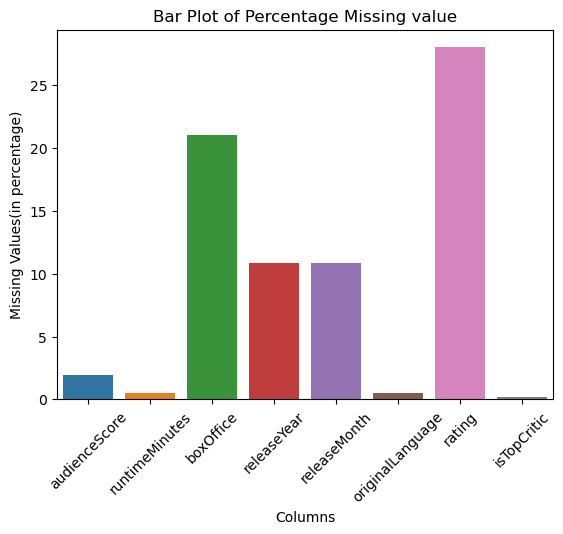

In [187]:
sns.barplot(x=temp_missing.column_name,y=temp_missing.percent_missing)
plt.xlabel('Columns')
plt.ylabel('Missing Values(in percentage)')
plt.title('Bar Plot of Percentage Missing value')
plt.xticks(rotation=45)

## audienceScore

In [188]:
# discriptive statistics
train_new.audienceScore.describe()

count    158460.000000
mean         65.614294
std          19.339819
min           0.000000
25%          51.000000
50%          69.000000
75%          82.000000
max         100.000000
Name: audienceScore, dtype: float64

<Axes: xlabel='audienceScore', ylabel='Count'>

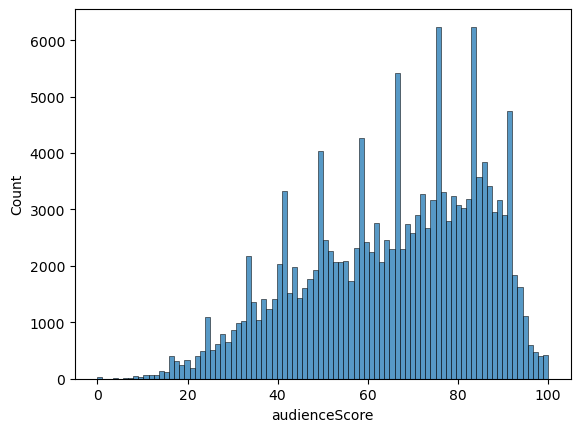

In [189]:
# histogram of audienceScore
sns.histplot(train_new,x="audienceScore")

In [190]:
# it seems that the audienceScore score is negatively skewed
train_new.audienceScore.skew()

-0.47031435119173753

Text(0.5, 1.0, 'Bar plot of audienceScore for different sentiment')

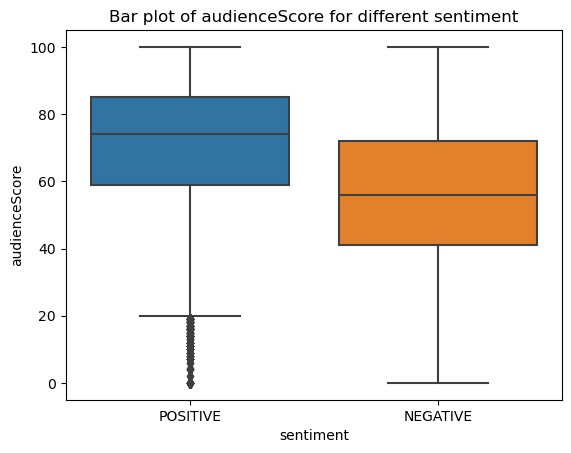

In [191]:
# bar plot of audienceScore for different sentiment
sns.boxplot(train_new,x=train_new.sentiment,y=train_new.audienceScore)
plt.title("Bar plot of audienceScore for different sentiment")

Text(0.5, 1.0, 'kde plot of audienceScore for different sentiment')

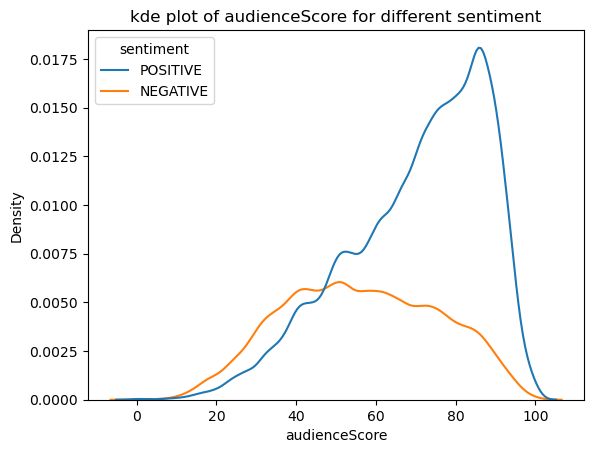

In [192]:
# kde plot of audienceScore for different sentiment
sns.kdeplot(train_new,x="audienceScore",hue='sentiment')
plt.title("kde plot of audienceScore for different sentiment")

In [193]:
temp_df=train_new.loc[:,["audienceScore","sentiment"]]

In [194]:
temp_df = temp_df.dropna(subset=['audienceScore'])

In [195]:
# Create two groups based on the Attrition_Flag categories
group1 = temp_df['audienceScore'][temp_df['sentiment'] == 'POSITIVE']
group2 = temp_df['audienceScore'][temp_df['sentiment'] == 'NEGATIVE']

# Perform the Mann-Whitney U test
statistic, p_value = mannwhitneyu(group1, group2)

# Print the test results
print("Mann-Whitney U test statistic:", statistic)
print("Mann-Whitney U test p-value:", p_value)

Mann-Whitney U test statistic: 3949090251.0
Mann-Whitney U test p-value: 0.0


**Conclusion**
- Have missing values around 1.77%.
- The distribution of audienceScore is negatively skewed and have skewness score -0.52.
- From the kdeplot and boxplot we can oberve the different distribution of audienceScore for Positive and Negative sentiment.
- From Mann-Whitney U Test we can conclude that audienceScore and sentiment is associated

## runtimeMinutes

In [196]:
# descriptive Statistics
train_new.runtimeMinutes.describe()

count    160885.000000
mean        108.474929
std          20.808562
min           4.000000
25%          95.000000
50%         105.000000
75%         119.000000
max         561.000000
Name: runtimeMinutes, dtype: float64

<Axes: xlabel='runtimeMinutes', ylabel='Count'>

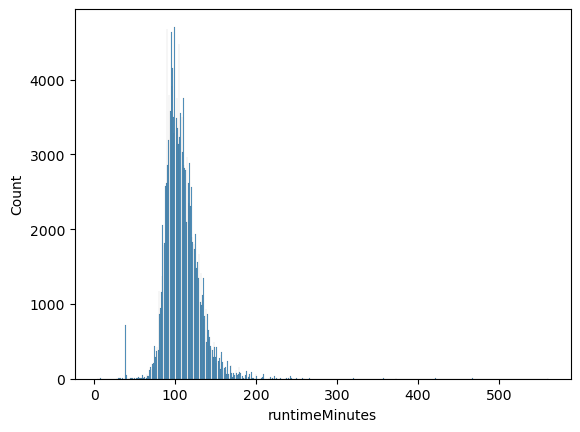

In [197]:
# histogram
sns.histplot(train_new,x="runtimeMinutes")

In [198]:
# it seems that the runtimeMinutes score is negatively skewed
train_new.runtimeMinutes.skew()

1.7468847842227269

Text(0.5, 1.0, 'Bar plot of runtimeMinutes for different sentiment')

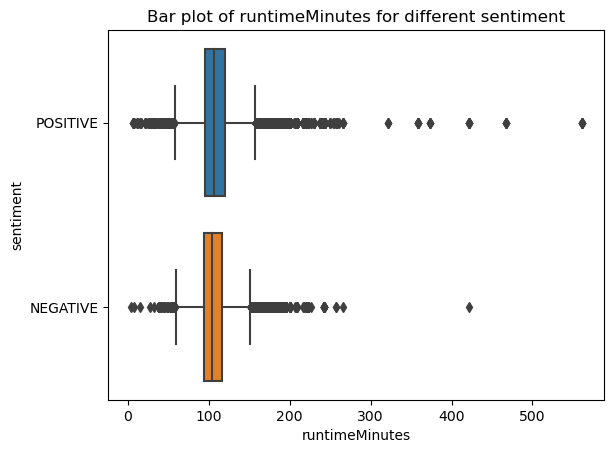

In [199]:
#box plot of runtimeMinutes
sns.boxplot(train_new,x="runtimeMinutes",y="sentiment")
plt.title("Bar plot of runtimeMinutes for different sentiment")

Text(0.5, 1.0, 'kdeplot of runtimeMinutes for different sentiment')

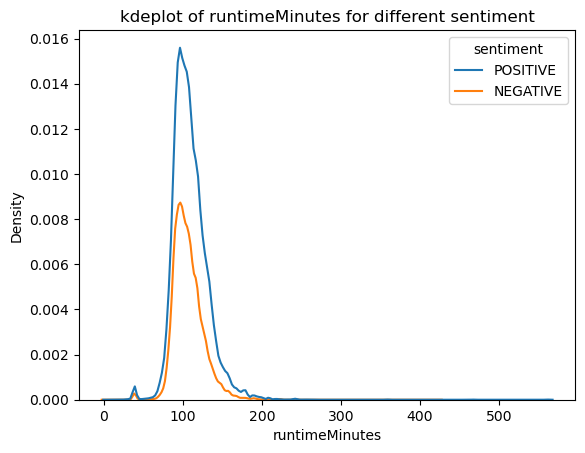

In [200]:
# kdeplot od runtimeMinutes
sns.kdeplot(train_new,x="runtimeMinutes",hue='sentiment')
plt.title("kdeplot of runtimeMinutes for different sentiment")

In [201]:
temp_df=train_new.loc[:,["runtimeMinutes","sentiment"]]

In [202]:
temp_df = temp_df.dropna(subset=['runtimeMinutes'])

In [203]:
# Create two groups based on the Attrition_Flag categories
group1 = temp_df['runtimeMinutes'][temp_df['sentiment'] == 'POSITIVE']
group2 = temp_df['runtimeMinutes'][temp_df['sentiment'] == 'NEGATIVE']

# Perform the Mann-Whitney U test
statistic, p_value = mannwhitneyu(group1, group2)

# Print the test results
print("Mann-Whitney U test statistic:", statistic)
print("Mann-Whitney U test p-value:", p_value)

Mann-Whitney U test statistic: 3048658644.5
Mann-Whitney U test p-value: 7.156511425269109e-91


**Conclusion**
- Shape of kdeplot for positive and negative is almost same but have diiferences.
- Highly positively distributed with skewness 1.74
- From Mann Whitney U Test we can conclude that runtimeMinutes is associated with sentiment

## boxOffice 

In [204]:
# discriptive statistics
train_new.boxOffice.describe()

count    1.275490e+05
mean     5.010399e+07
std      8.879199e+07
min      1.000000e+03
25%      1.100000e+06
50%      1.600000e+07
75%      5.830000e+07
max      8.584000e+08
Name: boxOffice, dtype: float64

Text(0.5, 1.0, 'Histogram of boxOffice')

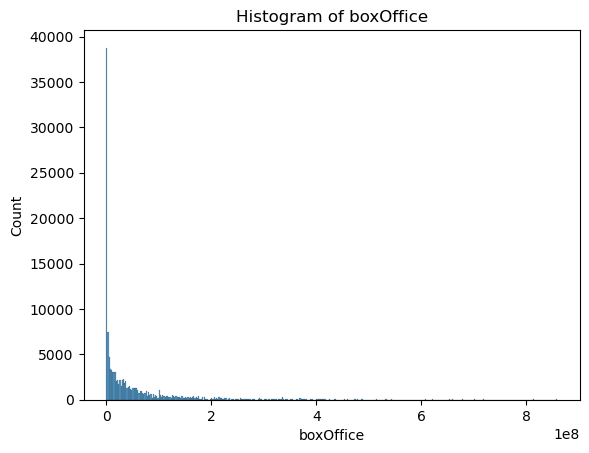

In [205]:
# histogram of boxOffice
sns.histplot(train_new,x="boxOffice")
plt.title("Histogram of boxOffice")

In [206]:
# it seems that the audienceScore score is negatively skewed
train_new.boxOffice.skew()

3.679537049849243

<Axes: xlabel='boxOffice', ylabel='Density'>

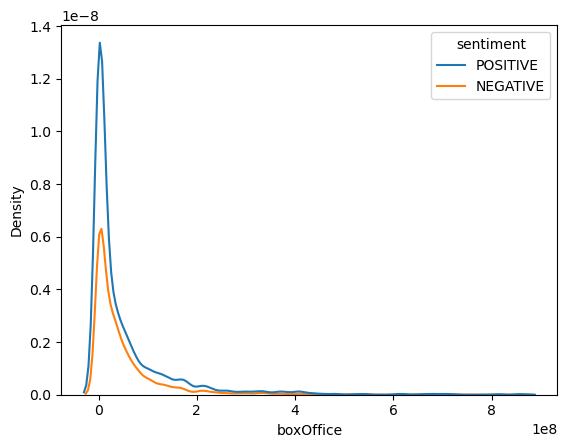

In [207]:
# kdeplot od runtimeMinutes
sns.kdeplot(train_new,x="boxOffice",hue='sentiment')

In [208]:
temp_df=train_new.loc[:,["boxOffice","sentiment"]]
temp_df = temp_df.dropna(subset=['boxOffice'])

In [209]:
# Create two groups based on the Attrition_Flag categories
group1 = temp_df['boxOffice'][temp_df['sentiment'] == 'POSITIVE']
group2 = temp_df['boxOffice'][temp_df['sentiment'] == 'NEGATIVE']

# Perform the Mann-Whitney U test
statistic, p_value = mannwhitneyu(group1, group2)

# Print the test results
print("Mann-Whitney U test statistic:", statistic)
print("Mann-Whitney U test p-value:", p_value)

Mann-Whitney U test statistic: 1681026239.5
Mann-Whitney U test p-value: 5.663867526623307e-156


**Conclusion**
- have 21% missing values
- Positively Skewed with skewness value 3.67
- A very small p-value indicates that boxOffice is associated with sentiment columns

# releaseYear

In [210]:
#missing value
#descriptive statistics
train_new.releaseYear.isnull().sum()/len(train_new.releaseYear)*100

10.827765404602822

In [211]:
#descriptive statistics
train_new.releaseYear.describe()

count    144138.000000
mean       2009.019967
std          12.786499
min        1913.000000
25%        2004.000000
50%        2012.000000
75%        2017.000000
max        2023.000000
Name: releaseYear, dtype: float64

Text(0.5, 1.0, 'kde plot of releaseYear for different sentiment')

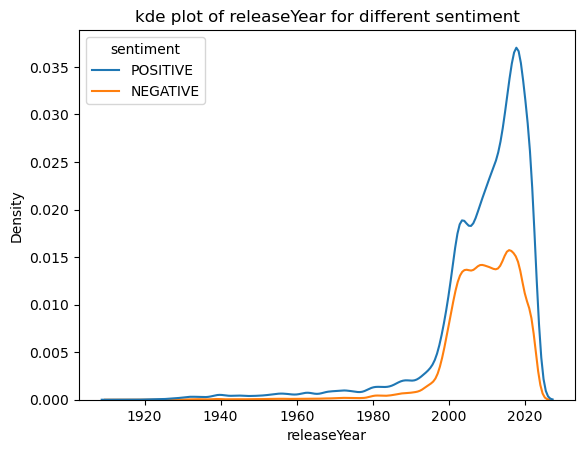

In [212]:
# kde plot of audienceScore for different sentiment
sns.kdeplot(train_new,x="releaseYear",hue='sentiment')
plt.title("kde plot of releaseYear for different sentiment")

In [213]:
temp_df=train_new.loc[:,["releaseYear","sentiment"]]
temp_df = temp_df.dropna(subset=['releaseYear'])

In [214]:
# Create two groups based on the Attrition_Flag categories
group1 = temp_df['releaseYear'][temp_df['sentiment'] == 'POSITIVE']
group2 = temp_df['releaseYear'][temp_df['sentiment'] == 'NEGATIVE']

# Perform the Mann-Whitney U test
statistic, p_value = mannwhitneyu(group1, group2)

# Print the test results
print("Mann-Whitney U test statistic:", statistic)
print("Mann-Whitney U test p-value:", p_value)

Mann-Whitney U test statistic: 2515687505.5
Mann-Whitney U test p-value: 1.4111113634874126e-152


**Conclusion**
- Have missing values around 10%.
- From the kdeplot and we can oberve the different distribution of releaseYear for Positive and Negative sentiment.
- A very small p-value indicates that releaseYear is associated to sentiment column

# releaseMonth

In [215]:
temp_df=pd.crosstab(index=train_new.sentiment,columns=train_new.releaseMonth)
temp_df

releaseMonth,April,August,December,February,January,July,June,March,May,November,October,September
sentiment,,,,,,,,,,,,
NEGATIVE,3883,4315,4095,3884,3732,3749,4014,4423,3837,3880,4573,4124
POSITIVE,7153,7898,9332,6095,6800,7631,8317,7818,7522,9660,9607,7796


<Axes: xlabel='releaseMonth', ylabel='sentiment'>

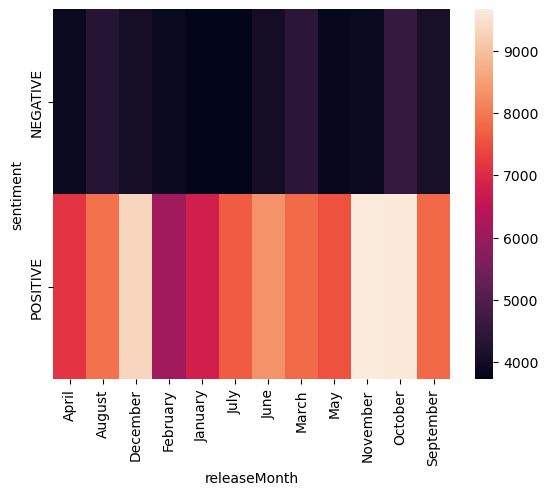

In [216]:
sns.heatmap(temp_df)

In [217]:
chi2, p_value, dof, expected = chi2_contingency(temp_df)
print("Chi-square statistic:", chi2)
print("P-value:", p_value)
print("Degrees of freedom:", dof)

Chi-square statistic: 437.6363223652399
P-value: 6.151494977935258e-87
Degrees of freedom: 11


**Conclusion**
- Have missing value, around 10%
- The heatmap's color intensity indicates the strength of the association between 'sentiment' and 'releaseMonth.'
- A small p-value indicates that releaseMonth is associated with sentiment column

## originalLanguage

In [218]:
train_new.originalLanguage

0                     English
1                     English
2                     English
3                     English
4         Portuguese (Brazil)
                 ...         
161635                English
161636                English
161637                English
161638                English
161639                English
Name: originalLanguage, Length: 161640, dtype: object

In [219]:
# number of unique launguagge in which movies are released
train_new.originalLanguage.nunique()

88

In [220]:
# top 10 launguages in which movies are released
train_new.originalLanguage.value_counts().head(10)

English                     138779
French (France)               3175
English (United Kingdom)      2879
French (Canada)               1978
Japanese                      1585
Spanish                       1422
Chinese                       1218
German                        1060
Korean                         770
Italian                        759
Name: originalLanguage, dtype: int64

## director

In [221]:
train_new.director.nunique()

8826

In [222]:
# top 10 movie directors
train_new.director.value_counts().head(10)

Billy Diaz          836
Michelle Numbers    706
Linda Shuffler      638
Jill Fraser         603
Michele Burton      554
Sheila Pereira      546
Norma Cole          489
Arnulfo Sewell      486
Amanda Wilson       441
Edgar Radden        419
Name: director, dtype: int64

## rating

In [223]:
train_new.rating

0         PG-13
1         PG-13
2         PG-13
3             R
4             R
          ...  
161635      NaN
161636    PG-13
161637    PG-13
161638      NaN
161639        R
Name: rating, Length: 161640, dtype: object

In [224]:
# unique rating values
train_new.rating.nunique()

7

In [225]:
# value count
train_new.rating.value_counts()

R        59017
PG-13    43261
PG       13677
NC-17      277
TVMA        46
TVPG        37
TV14        14
Name: rating, dtype: int64

In [226]:
temp_df=pd.crosstab(index=train_new.sentiment,columns=train_new.rating)
temp_df

rating,NC-17,PG,PG-13,R,TV14,TVMA,TVPG
sentiment,,,,,,,
NEGATIVE,78,4824,17717,19878,6,9,8
POSITIVE,199,8853,25544,39139,8,37,29


<Axes: xlabel='rating', ylabel='sentiment'>

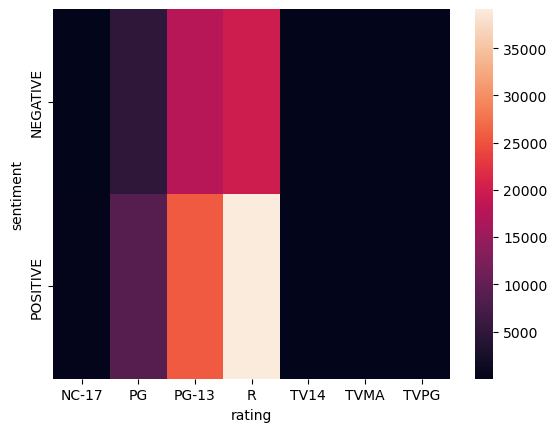

In [227]:
sns.heatmap(temp_df)

In [228]:
chi2, p_value, dof, expected = chi2_contingency(temp_df)
print("Chi-square statistic:", chi2)
print("P-value:", p_value)
print("Degrees of freedom:", dof)

Chi-square statistic: 598.6767186554457
P-value: 4.499857375932248e-126
Degrees of freedom: 6


**Conclusion**
- Have some missing values around 28%
- The heatmap's color intensity indicates the strength of the association between 'sentiment' and 'rating.'
- A small p-value indicates that rating is associated to sentiment column

## reviewerName

In [229]:
train_new.reviewerName

0              Benjamin Henry
1               Felicia Lopez
2         Mr. Charles Burgess
3                Ryan Barrett
4            Alexander Glover
                 ...         
161635          Danny Mueller
161636       Jennifer Clayton
161637           Bryan Wilson
161638            Erik Parker
161639           Howard Evans
Name: reviewerName, Length: 161640, dtype: object

In [230]:
# number of unique reviewers
train_new.reviewerName.nunique()

4482

In [231]:
# top 10 reviewers
train_new.reviewerName.value_counts().head(10)

Sherri Morrison      945
Veronica Serrano     940
Mrs. Vickie Young    825
Kristy Ferguson      819
James Newman         790
Heather Pena         789
John Luna            777
Danielle Jimenez     723
Shelley Murillo      697
Bryan Phillips       667
Name: reviewerName, dtype: int64

**Conclusion**
- There are 4482 unique reviewers
- No missing value


## isFrequentReviewer

In [232]:
train_new.isFrequentReviewer.value_counts()

False    112389
True      49251
Name: isFrequentReviewer, dtype: int64

In [233]:
train_new.isFrequentReviewer.isnull().sum()

0

In [234]:
temp_df=pd.crosstab(index=train_new.sentiment,columns=train_new.isFrequentReviewer)
temp_df

isFrequentReviewer,False,True
sentiment,,
NEGATIVE,35516,18110
POSITIVE,76873,31141


<Axes: xlabel='isFrequentReviewer', ylabel='sentiment'>

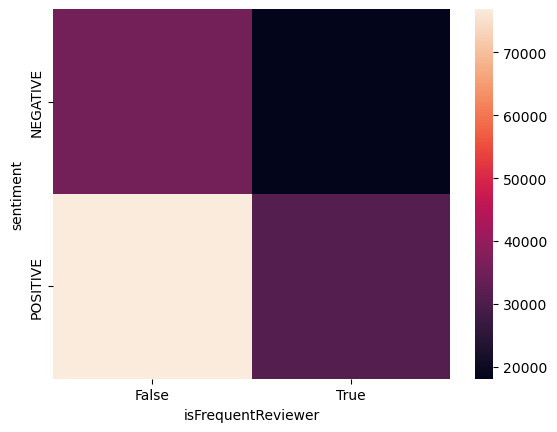

In [235]:
sns.heatmap(temp_df)

In [236]:
chi2, p_value, dof, expected = chi2_contingency(temp_df)
print("Chi-square statistic:", chi2)
print("P-value:", p_value)
print("Degrees of freedom:", dof)

Chi-square statistic: 412.6160166295441
P-value: 9.878504455875817e-92
Degrees of freedom: 1


**Conclusion**
- No missing Value
- The heatmap's color intensity indicates the strength of the association between 'sentiment' and 'isFrequentReviewer.'
- A small p-value in the chi-square test indicates that there is a statistically significant association between 'isFrequentReviewer' and 'sentiment'.This means that the sentiment of reviews may be related to whether the reviewer is a frequent reviewer or not. 

## isTopCritic

In [237]:
train_new.isTopCritic.isnull().sum()

318

In [238]:
train_new.isTopCritic.value_counts()

False    110850
True      50472
Name: isTopCritic, dtype: int64

In [239]:
temp_df=pd.crosstab(index=train_new.sentiment,columns=train_new.isTopCritic)
temp_df

isTopCritic,False,True
sentiment,,
NEGATIVE,34927,18617
POSITIVE,75923,31855


<Axes: xlabel='isTopCritic', ylabel='sentiment'>

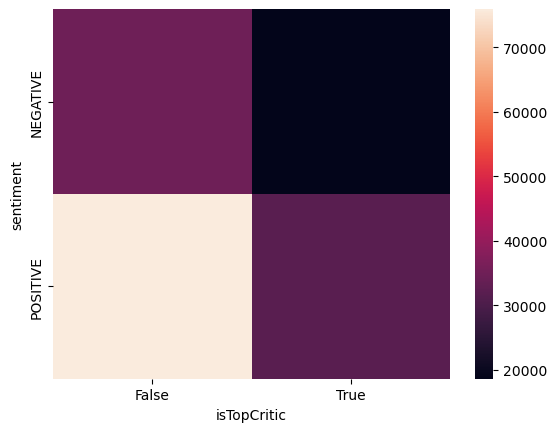

In [240]:
sns.heatmap(temp_df)

In [241]:
chi2, p_value, dof, expected = chi2_contingency(temp_df)
print("Chi-square statistic:", chi2)
print("P-value:", p_value)
print("Degrees of freedom:", dof)

Chi-square statistic: 452.0217115129711
P-value: 2.6190113642843135e-100
Degrees of freedom: 1


**Conclusion**
- Have some missing Value
- The heatmap's color intensity indicates the strength of the association between 'sentiment' and 'isTopCritic.'
- A small p-value in the chi-square test indicates that there is a statistically significant association between 'isTopCritic' and 'sentiment'.This means that the sentiment of reviews may be related to whether the reviewer is top critic or not. 

**Undersating the association between isFrequentReviewer and isTopCritic**

In [242]:
# Creating the contingency table
contingency_table=pd.crosstab(index=train_new.isFrequentReviewer,columns=train_new.isTopCritic)
contingency_table

isTopCritic,False,True
isFrequentReviewer,,
False,108206,3962
True,2644,46510


In [243]:
# Calculate Cramér's V
chi2, p, dof, expected = chi2_contingency(contingency_table)
n = contingency_table.sum().sum()
V = np.sqrt(chi2 / (n * (min(contingency_table.shape) - 1)))

In [244]:
print("The value of V for Cramer's V ", V)

The value of V for Cramer's V  0.9042296648141066


**Conclusion**
- A value of 0.9042 indicates a strong association between the two categorical variables being tested. This means that there is a significant relationship between the two variables, and changes in one variable are associated with changes in the other variable. So we can drop any one feature from these two feature.

In [245]:
# Deleting isTopCritic feature from training set and test set
# also the movieid column is not required
train_new.drop(["movieid","isTopCritic"],axis=1,inplace=True)
test_new.drop(["movieid","isTopCritic"],axis=1,inplace=True)

# Building Pipeline for Data Processing

In [246]:
train_new.head()

,audienceScore,runtimeMinutes,boxOffice,releaseYear,releaseMonth,originalLanguage,director,rating,reviewerName,isFrequentReviewer,sentiment,combined_text
0,65.0,105.0,NaN,2022.0,October,English,Bennie Basso,PG-13,Benjamin Henry,False,POSITIVE,Violence Brief Strong Language Substan...
1,47.0,119.0,110500000.0,2010.0,February,English,Hubert Dixon,PG-13,Felicia Lopez,False,NEGATIVE,Some Sexual Material Brief Partial Nudity...
2,80.0,130.0,115700000.0,2018.0,November,English,Bobby Oleary,PG-13,Mr. Charles Burgess,True,POSITIVE,Language A Scene of Sensuality Sports ...
3,47.0,88.0,126500000.0,2014.0,July,English,Gail Pugh,R,Ryan Barrett,False,POSITIVE,Sexuality Disturbing Images Strong Vio...
4,97.0,131.0,7600000.0,2003.0,January,Portuguese (Brazil),John Trent,R,Alexander Glover,False,POSITIVE,Language Drug Content Sexuality Str...


## Dividing the training set into feature matrix and target variable

In [247]:
X=train_new.drop(["sentiment"],axis=1)
y=train_new.sentiment

In [248]:
X.head()

,audienceScore,runtimeMinutes,boxOffice,releaseYear,releaseMonth,originalLanguage,director,rating,reviewerName,isFrequentReviewer,combined_text
0,65.0,105.0,NaN,2022.0,October,English,Bennie Basso,PG-13,Benjamin Henry,False,Violence Brief Strong Language Substan...
1,47.0,119.0,110500000.0,2010.0,February,English,Hubert Dixon,PG-13,Felicia Lopez,False,Some Sexual Material Brief Partial Nudity...
2,80.0,130.0,115700000.0,2018.0,November,English,Bobby Oleary,PG-13,Mr. Charles Burgess,True,Language A Scene of Sensuality Sports ...
3,47.0,88.0,126500000.0,2014.0,July,English,Gail Pugh,R,Ryan Barrett,False,Sexuality Disturbing Images Strong Vio...
4,97.0,131.0,7600000.0,2003.0,January,Portuguese (Brazil),John Trent,R,Alexander Glover,False,Language Drug Content Sexuality Str...


In [249]:
y.head()

0    POSITIVE
1    NEGATIVE
2    POSITIVE
3    POSITIVE
4    POSITIVE
Name: sentiment, dtype: object

In [250]:
test_new.head()

,audienceScore,runtimeMinutes,boxOffice,releaseYear,releaseMonth,originalLanguage,director,rating,reviewerName,isFrequentReviewer,combined_text
0,57.0,111.0,64000000.0,2022.0,October,English,Sara Barnett,R,John Kim,False,Gore Bloody Horror Violence Language T...
1,86.0,94.0,6200000.0,2002.0,November,English,Cindy Flander,PG,Brian Chaney,False,Emotional Thematic Material Drama Adventu...
2,NaN,107.0,NaN,NaN,NaN,French (France),Kurt Boyer,NaN,Danielle Parker,False,nan Drama nan nan It wouldn t do to say what p...
3,70.0,108.0,NaN,2019.0,February,Persian,Benjamin Daniel,NaN,Brittany Lane,False,nan Comedy Daricheh Cinema Dolby Digital Pig i...
4,NaN,66.0,NaN,NaN,NaN,Arabic,Marvin Short,NaN,Justin Willis,False,nan Drama Musical nan nan An imaginative no b...


## Changing type of boolean columns
Simple inmputer does not work with boolean data type so we will have to change its data type

In [251]:
X["isFrequentReviewer"] = X["isFrequentReviewer"].astype(str)
test_new["isFrequentReviewer"]=test_new["isFrequentReviewer"].astype(str)

## Creating Pipeline

In [283]:
# Create transformers for different types of columns
numeric_features = ['audienceScore', 'runtimeMinutes', 'boxOffice', 'releaseYear']
numeric_transformer = Pipeline(steps=[
    ('imputer', KNNImputer(n_neighbors=2))
    ,('scaler', MaxAbsScaler())
])

categorical_features = ['releaseMonth','originalLanguage','director','rating','reviewerName','isFrequentReviewer']
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(drop='first',handle_unknown='ignore'))
])

text_features = 'combined_text'
text_transformer = TfidfVectorizer(lowercase=True,stop_words='english')

# Combine all transformers using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features),
        ('text', text_transformer, text_features)
    ]
)

preprocessor

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  KNNImputer(n_neighbors=2)),
                                                 ('scaler', MaxAbsScaler())]),
                                 ['audienceScore', 'runtimeMinutes',
                                  'boxOffice', 'releaseYear']),
                                ('cat',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehot',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'))]),
                                 ['releaseMonth', 'originalLanguage',
                                  'director', 'rating', 'reviewerName',
                                  'isFrequentReviewer']),
                                ('text', TfidfVectorizer(stop_words='english'),
                                 'combined_text')])

# Model Fitting

## Train Test Split

In [254]:
X_train, X_val, y_train, y_val=train_test_split(X,y,test_size=0.2,random_state=42,stratify=y)

In [255]:
X_train.head()

,audienceScore,runtimeMinutes,boxOffice,releaseYear,releaseMonth,originalLanguage,director,rating,reviewerName,isFrequentReviewer,combined_text
128881,79.0,126.0,71500000.0,2004.0,October,English,John Murrell,R,Mr. Travis Vargas,False,Nudity Language Some Strong Sexual Con...
132084,76.0,150.0,58100000.0,2020.0,September,English,Edgar Radden,PG-13,Krystal Hardy,False,Brief Strong Language Action Intense S...
152529,91.0,98.0,217400000.0,2010.0,March,English,Robert Ross,PG,Howard Evans,False,Sequences of Intense Action Brief Mild La...
157256,63.0,107.0,118600000.0,2004.0,December,English,Joseph Brooks,PG,Brandon Gamble,False,Scary Situations Brief Language Themat...
112036,96.0,125.0,90000000.0,2022.0,July,English,David Held,PG-13,Brittany Saunders,True,Sexual Content A Sexual Assault Some V...


In [256]:
X_val.head()

,audienceScore,runtimeMinutes,boxOffice,releaseYear,releaseMonth,originalLanguage,director,rating,reviewerName,isFrequentReviewer,combined_text
58124,88.0,94.0,58100.0,1948.0,September,English,William Bruff,NaN,Vanessa Lin,False,nan Mystery thriller Criterion Collection S...
126291,71.0,142.0,1100000.0,2017.0,October,English,Robert Dillahunt,R,Dominique Curtis,True,Language Brief Violence Some Strong Se...
153145,75.0,112.0,127000000.0,2011.0,June,English,Keith Morales,PG-13,Robert Faulkner,True,Intense Seq of Sci Fi Violenc Intense Se...
1492,74.0,93.0,163500000.0,1999.0,June,English,Mary Hough,PG-13,Brittany Ayers,True,Some Crude Humor Language Comedy Columb...
98548,84.0,132.0,11100000.0,1996.0,September,English,Diane Batdorf,NaN,Laura Lawrence,False,nan History Drama nan Surround Makes it clear...


In [257]:
y_train.head()

128881    POSITIVE
132084    POSITIVE
152529    POSITIVE
157256    POSITIVE
112036    POSITIVE
Name: sentiment, dtype: object

In [258]:
y_val.head()

58124     POSITIVE
126291    NEGATIVE
153145    POSITIVE
1492      NEGATIVE
98548     POSITIVE
Name: sentiment, dtype: object

## Label Encoding

In [259]:
# instantiating label encoder object
le = LabelEncoder()

In [260]:
# fitting label encoder
le.fit(y_train)

LabelEncoder()

In [261]:
# transforming label encoder
y_train=le.transform(y_train)
y_val=le.transform(y_val)

## Applying Models

### Logistic Regression

In [287]:
log=LogisticRegressionCV(random_state=42,max_iter=500,n_jobs=-1,solver="lbfgs",cv=3)

In [ ]:
log_pipe=make_pipeline(preprocessor,log)
log_pipe

In [282]:
log.fit(X_train_processed,y_train)

KeyboardInterrupt: 

In [ ]:
y_log=log.predict(X_val_processed)

In [ ]:
cm=confusion_matrix(y_val,y_log)
cm_display=ConfusionMatrixDisplay(cm)
cm_display.plot()

In [ ]:
print(classification_report(y_val,y_log))

### Decision Tree

In [ ]:
dt=DecisionTreeClassifier(random_state=42)

In [ ]:
dt.fit(X_train_processed,y_train)

In [ ]:
y_dt=dt.predict(X_val_processed)

In [ ]:
f1_score(y_val,y_dt)

In [ ]:
cm=confusion_matrix(y_val,y_dt)
cm_display=ConfusionMatrixDisplay(cm)
cm_display.plot()

In [ ]:
print(classification_report(y_val,y_dt))

### Random Forest

In [ ]:
rf = RandomForestClassifier(random_state=42)

In [ ]:
rf.fit(X_train_processed,y_train)

In [ ]:
y_rf=rf.predict(X_val_processed)

In [ ]:
f1_score(y_val,y_rf)

In [ ]:
cm=confusion_matrix(y_val,y_rf)
cm_display=ConfusionMatrixDisplay(cm)
cm_display.plot()

In [ ]:
print(classification_report(y_val,y_rf))

**Conclusion**
- LogisticsRegressionCV is giving good f1_score so let's fit the whole data on logistic regression 

### Fitting model on whole data

In [ ]:
y=le.fit_transform(y)

In [ ]:
log=LogisticRegressionCV(random_state=42,max_iter=1000,n_jobs=-1,solver="saga",class_weight="balanced",cv=3)

In [ ]:
log_pipe=make_pipeline(preprocessor,log)
log_pipe

In [ ]:
log_pipe.fit(X,y)

In [ ]:
y_test_predicted=log_pipe.predict(test_new)

# Making Submission.csv

In [ ]:
submission=pd.DataFrame(columns=["id","sentiment"])
submission["id"]=[i for i in range(len(y_test_predicted))]
submission['sentiment']=le.inverse_transform(y_test_predicted)

In [ ]:
submission

In [ ]:
submission.to_csv("submission.csv",index=False)